# CS413 Image and Video Analysis -- Lab 3

## Department of Computer Science, University of Warwick
## July, 2019

## Aims:

The aims of this lab are to

+ Learn how to apply pixel-wise, intensity modifications to change image contrast
+ Perform histogram equalisation and histogram matching on images
+ Use image convolution to blur and shapen images
+ Perform Gaussian convolutions and Laplacian operations to find edges at zero-crossings
+ Implement and use the REDUCE and EXPAND operations to build an image pyramid
+ Use a Gaussian/Laplacian Pyramid to perform image compression

## Contrast Modifications

We can implement image constrast modification by changing the intensity of the image pixels according to a
predefined function. We have to be careful to make sure that the range of the function matches the domain:
    i.e. if the input is in the range `0..255` the output is also in the same range.
    
For example, a gamma modification take the form: 
$
    T(x) = 255 \times \left( \frac{x}{255} \right)^{\gamma}
$
where $\gamma$ can be $<0$ or $>0$.


## Exercise 1

1. Define a function to do gamma modification of the image intensity:

~~~~
    def gamma_contrast(im, gamma=0):
    
        ...
        
        return im_gamma
~~~~

Hint: You can use `numpy.power()` to apply an exponent to all the values of an array, e.g.
~~~~
    a = np.random.randint(10, size=10)

    print(a) # random array of 10 numbers
    print(np.power(a, 0.5)) # print square root of all values a
~~~~

To convert the input to floating point, you can use, `numpy.astype('float')`, e.g.
~~~~
    im_float = im.astype('float')
    
    # ...do some processing as float
    
    # convert back to uint8
    im_uint8 = im_float.astype('uint8')
~~~~

2. Test your function on `zelda.pgm` for different gamma values in the range `[-3.0, 3.0]`.

3. How would you apply your function to a colour image, like `zelda-color.bmp`?

In [2]:
def gamma_contrast(im, gamma):
        divide = np.divide(im.astype(float),255)
        power = np.power(divide,gamma)
        multiply = np.multiply(power,255)
        return multiply


In [4]:
# import statements

from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 

import matplotlib.pyplot as plt # this is for plotting (showing) images 
data_dir = '/modules/cs413/data/'

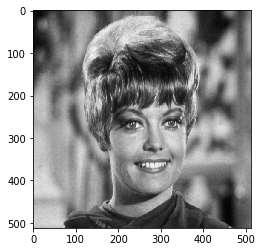

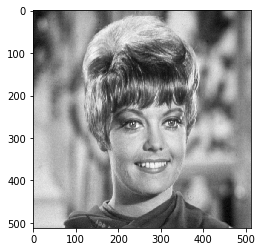

In [5]:
im = Image.open(data_dir + 'zelda.pgm').convert('L')
img=np.asarray(im)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(gamma_contrast(img, 0.8), cmap='gray')
plt.show()

## Histogram Equalisation

As the name suggest, histogram equalisation tries to modify the contrast of an image so that the 
histogram of the resultant image is uniform, i.e. all the colour/intensity values are equally represented.

To perform equalisation we can use the cumulative histogram (or CDF) and work out a scaling factor for each
colour which will take its current frequency up to (or down to) the cumulative sum.

To implement histogram equalisation from first principles, we need to:
    
    1. Calculate the image histogram
    2. Normalise the histogram to make it into a PDF
    3. Cumulative sum the PDF to make it a CDF
    4. Apply a scaling factor of $ S(i) = 255 \times CDF[i] $
    
## Exercise 2

1. Implement histogram equalisation defining a function to return an equalised image:
~~~~
    def equalise(im):
    
        return im_equalised
~~~~

Hint: You should use `numpy.histogram` to calcualte the image histogram in to 256 bins and `numpy.cumsum` 
to cumulate the values in the histogram.
~~~~
    n = im.size
    hist, bins = np.histogram(im, bins=256) # histogram 
    pdf = hist/n # normalise it to make it a PDF
    cdf = np.cumsum(pdf) # make it cumulative
    
    # map all pixel values x to 255 * cdf[x]
    # (you can do this with a list comprehension if you are being clever)
    
~~~~

2. Plot the histograms of the original and the equalised images, e.g.
~~~~
    plt.hist(im_equalised.ravel(), bins=64)
    plt.imshow()
~~~~

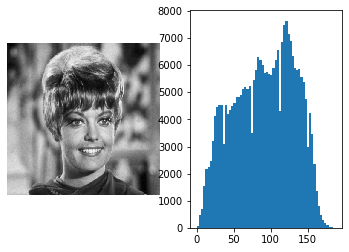

(512, 512)
262144


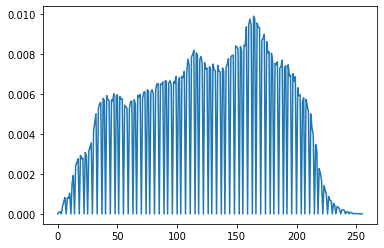

262144


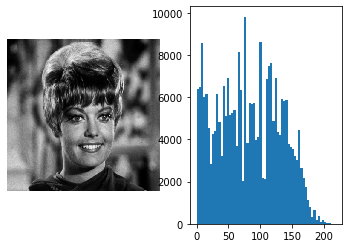

In [6]:
# I will help you...

def equalise(im):
    n = im.size
    print(im.shape)
    print(n)
    hist, bins = np.histogram(im, bins=256) # histogram 
    pdf = hist/n # normalise it to make it a PDF
    cdf = np.cumsum(pdf) # make it cumulative
    plt.plot(pdf)
    plt.show()
    # map array values using list comprehension?!
    im_equalised=np.copy(im.ravel())
    print(len(im.ravel()))
    for p in range(len(im.ravel())):
        im_equalised[p] = 255*cdf[(im.ravel()[p])]
    im_equalised2 = np.reshape(im_equalised,(512,512))
    return im_equalised2
    
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.hist(img.ravel(), bins=64)
plt.show()


im_equalised = equalise(img)

plt.subplot(1,2,1)
plt.imshow(im_equalised, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.hist(im_equalised.ravel(), bins=64)
plt.show()

## Convolution

Convolution is a local operation which is performed on a square region of pixels using a set of weights
of the same size as the region (the convolution filter or convolution kernel). We can specify the 
convolution kernel by a matrix (or simply as a small `numpy.arrray`).

The operation is an inner product (dot product) between the local region pixel values and the kernel 
values. For example, the operation at pixel `[i, j]` can be written as:
~~~~
    
    h = kernel.shape[0]//2 # half the kernel size
        
    # flatten the input arrays to 1D so dot product results in a scalar
    output[i, j] = np.dot(input[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
~~~~
In this example, we need to make sure that we do not attempt to index array values outside the 
boundary of the image, so to do it for all output values we might do:
~~~~
    
    output = np.zeros(input.shape, dtype='float')
    
    for i in range(h,input.shape[0]-h):
        for j in range(h,input.shape[1]-h):
            
            output[i, j] = np.dot(input[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
            
~~~~

## Exercise 3

1. Use the code snippets above to define a funciton to perform 2D image convolution on a given input image:
    
~~~~
    def conv2d(im, kernel):
        
        # perform convolution of kernel with im
        
        return output
~~~~
Note: strictly speaking, the input kernel should be applied transposed (but we won't worry about that!).
                                                                        
                                                                       
2. Test your convolition with the following image kernels:

~~~~
    kernel_1 = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]]) # what does this do to the image?
    kernel_2 = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]) # what does this do?
    kernel_2 = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]]) # what does this do?
~~~~

3. Take the output of the operation with `kernel_1` and subtract it from the original. What does this look like?


In [7]:
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    output = np.zeros(im.shape, dtype='float')

    for i in range(h,im.shape[0]-h):
        for j in range(h,im.shape[1]-h):

            output[i, j] = np.dot(im[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())

    return output

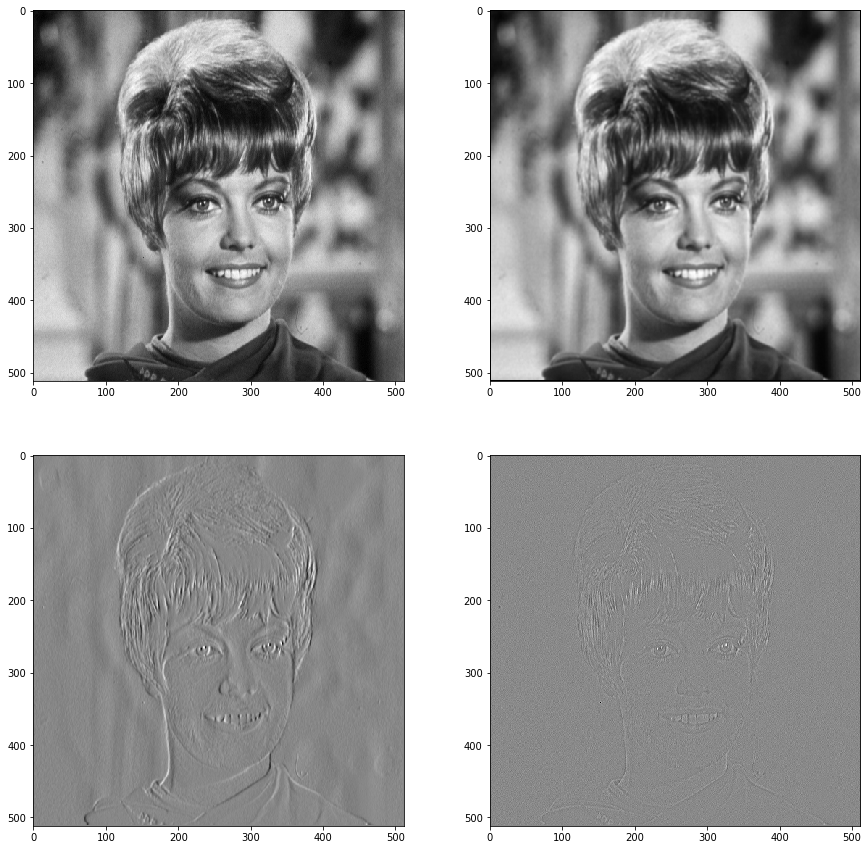

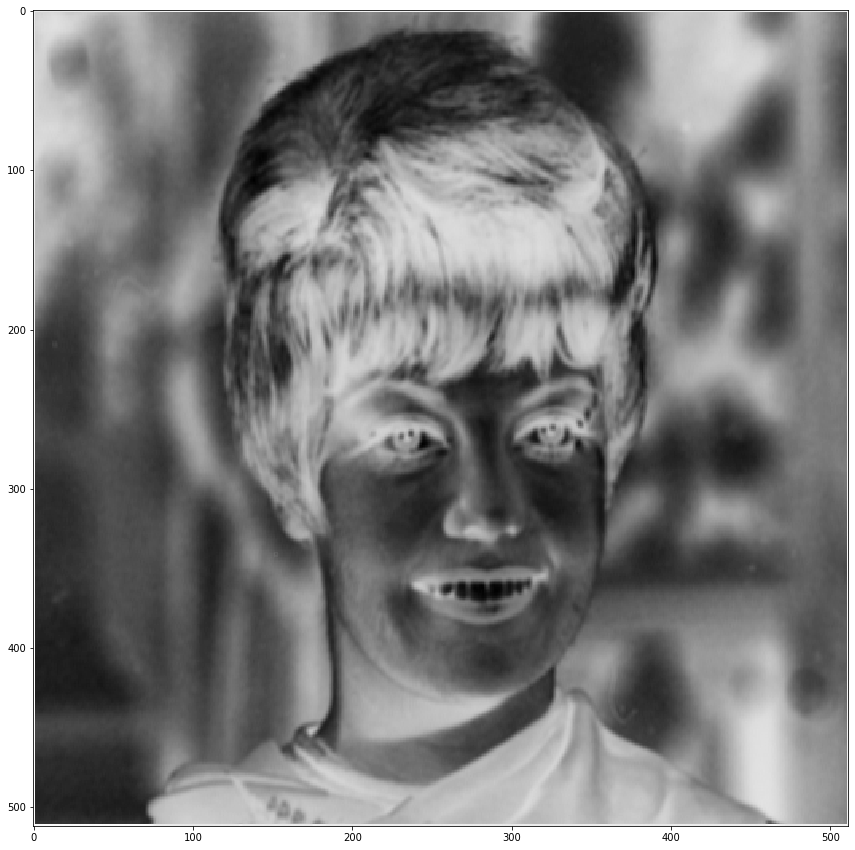

In [77]:
fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(img,cmap='gray')
plt.subplot(2,2,2)
kernel_1 = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]]) # averaging smoothing
plt.imshow(conv2d(img,kernel_1),cmap='gray')
plt.subplot(2,2,3)
kernel_2 = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]) # x-gradient
plt.imshow(conv2d(img,kernel_2),cmap='gray')
plt.subplot(2,2,4)
kernel_3 = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]]) # edge detection/sharpening
plt.imshow(conv2d(img,kernel_3),cmap='gray')
plt.show()
plt.figure(figsize=(15,15))
plt.imshow(img-conv2d(img,kernel_1),cmap='gray')
plt.show()

## Gaussian convolution

We can use the Gaussian function to create a set of weights for a kernel. This has many useful benefits, not least
being able to differentiate the kernel values analytically so that we can create kernels with edge detection
and noise suppression properties.

All Gaussain function take the general form $ g(x; \sigma) = \exp(-\frac{-x^2}{2\sigma^2}) $.

A 2D Gaussian function has the form

$
    g(x, y; \sigma) = \exp\left[ -\frac{x^2 + y^2}{2 \sigma^2} \right]\\
$
where $ \sigma $ controls the spread of the kernel.




In [8]:
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel


# let's make some Gaussian kernels
g1 = gaussian_kernel(0.5)

print(g1)

g2 = gaussian_kernel(1)

print(g2)

[[0.01134374 0.08381951 0.01134374]
 [0.08381951 0.61934703 0.08381951]
 [0.01134374 0.08381951 0.01134374]]
[[1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [1.76900911e-03 2.15509428e-02 9.65846250e-02 1.59241126e-01
  9.65846250e-02 2.15509428e-02 1.76900911e-03]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]]


## How to visualise the kernels?

To help visualise the kernel, we can use the `matplotlib` 3D plotting routines, as follows.

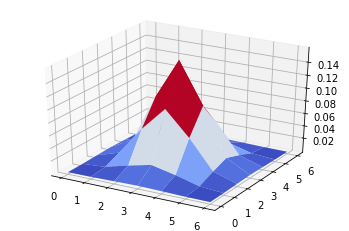

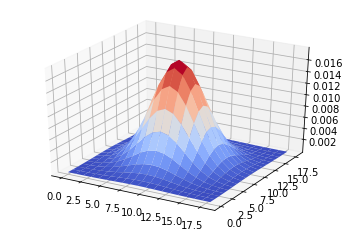

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def surface_plot(im):
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:im.shape[0], 0:im.shape[1]]

    # create the figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(xx, yy, im, cmap=cm.coolwarm)
    plt.show()

surface_plot(g2)

g3 = gaussian_kernel(3)
surface_plot(g3)


## Gaussian blurring

To apply the kernels, you could use the method you wrote earlier (`conv2d`), but not unsurprisingly
Python already has efficient built-in convolution function in the `scipy.ndimage` library. 

The `convolve` function can do n-dimensional convolutions if you like.

~~~~
    from scipy import ndimage
    
    output = ndimage.convolve(im, g1, mode='mirror') # mirror the border values

~~~~
You can also specify how it deals with the borders (when the kernel `falls-off' the image.)
                                                    
## Exercise 4
                                                    
1. Create and apply some small Gaussian kernels and show the effect of increasing the sigma (spread) parameter
in the range `[0.25,3.5]`.
                                                    
2. Repeat the unsharp-masking test where you subtract the blurred output from the original image.

3. Make a Difference of Gaussians kernel by subtracting a Gaussian kernel with a small sigma from one with a larger sigma. Visualise this kernel and test its effect on an image.

Note: To make the DoG kernel, you will have to ensure that both kernels are of the same size. You can pad the smaller
array with zeros e.g.
~~~
    # extend the size of small to be same shape as big
    
    small_padded = np.pad(small, (big.shape[0]-big.shape[0])//2, 'constant')
    
    diff = big - small_padded # now we can subtract them
~~~
                                                    

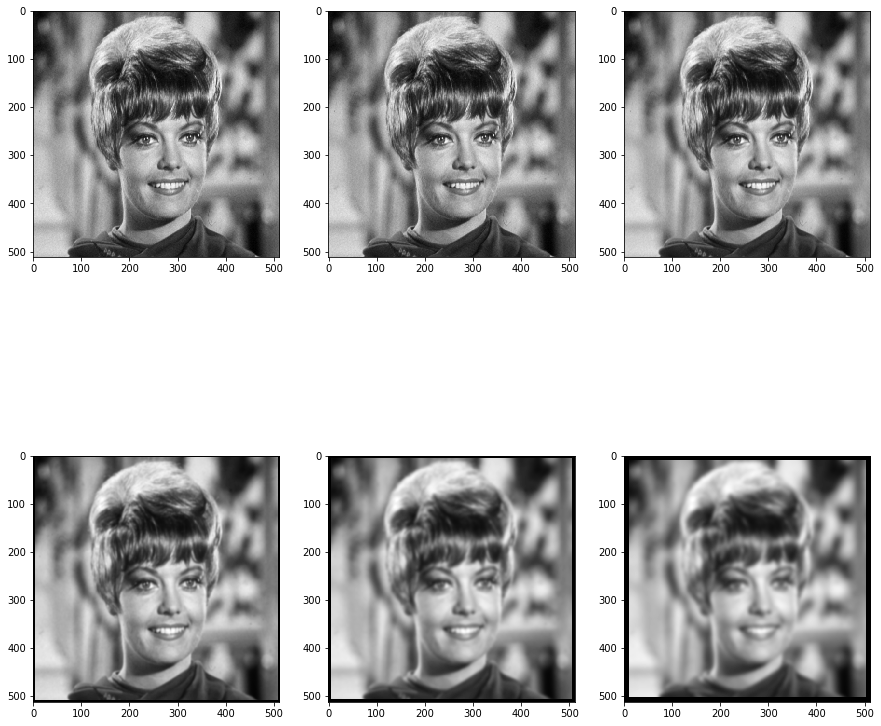

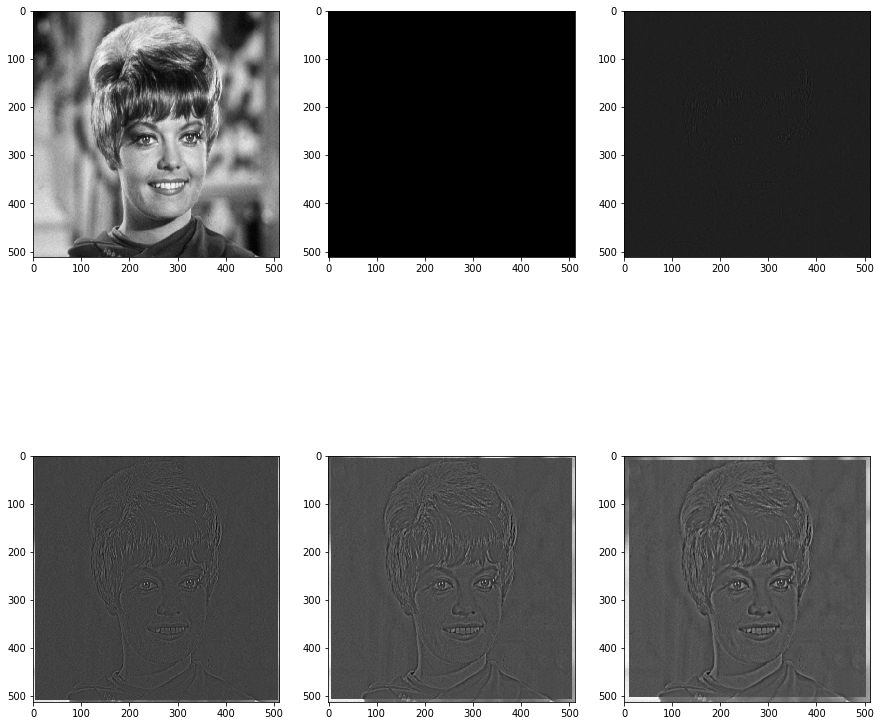

In [84]:
g1 = gaussian_kernel(1.5)
g2 = gaussian_kernel(2.5)
g3 = gaussian_kernel(3.5)
g5 = gaussian_kernel(0.5)
g4 = gaussian_kernel(0.25)

plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
plt.imshow(img,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(conv2d(img,g4),cmap='gray')
plt.subplot(2,3,3)
plt.imshow(conv2d(img,g5),cmap='gray')
plt.subplot(2,3,4)
plt.imshow(conv2d(img,g1),cmap='gray')
plt.subplot(2,3,5)
plt.imshow(conv2d(img,g2),cmap='gray')
plt.subplot(2,3,6)
plt.imshow(conv2d(img,g3),cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
plt.imshow(img,cmap='gray')
plt.subplot(2,3,2)
plt.imshow(img-conv2d(img,g4),cmap='gray')
plt.subplot(2,3,3)
plt.imshow(img-conv2d(img,g5),cmap='gray')
plt.subplot(2,3,4)
plt.imshow(img-conv2d(img,g1),cmap='gray')
plt.subplot(2,3,5)
plt.imshow(img-conv2d(img,g2),cmap='gray')
plt.subplot(2,3,6)
plt.imshow(img-conv2d(img,g3),cmap='gray')
plt.show()


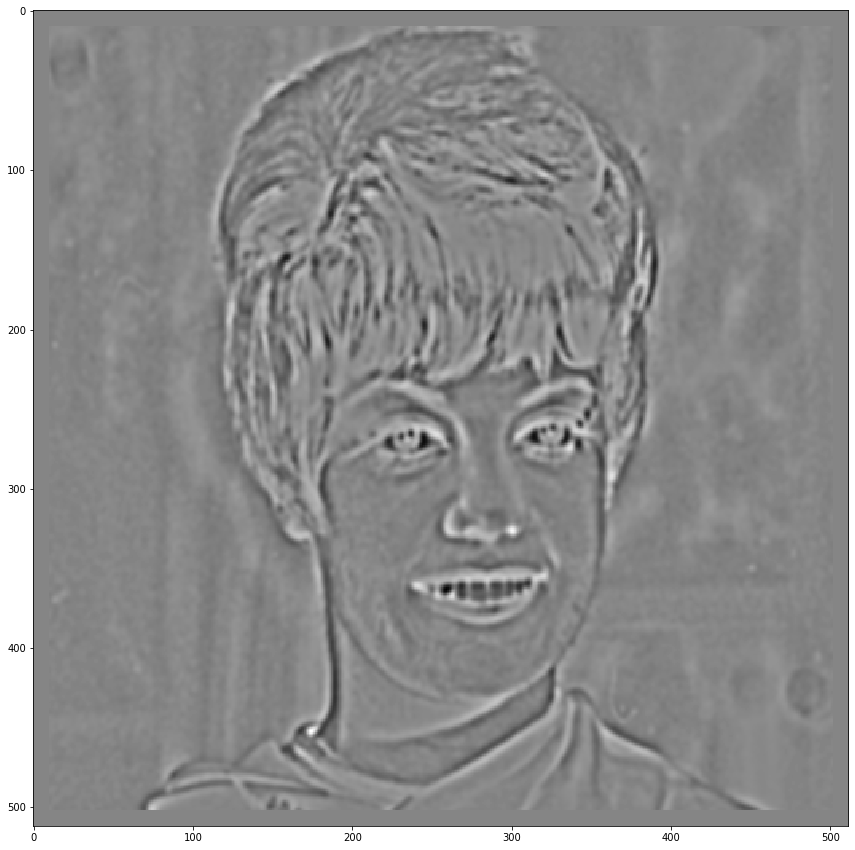

In [99]:
# extend the size of small to be same shape as big
small_padded = np.pad(g1, (g3.shape[0]-g1.shape[0])//2, 'constant')
dogtest = g3 - small_padded # now we can subtract them

#print(dogtest)
plt.figure(figsize=(15,15))
plt.imshow(conv2d(img,dogtest),cmap='gray')
plt.show()

## Difference of Gaussian Kernels (DoG)

If you did the last part of Exercise 4, you will have made a DoG kernel and seen how the kernel is in effect
a high-pass filter.

Instead of making a DoG kernel explicity and the convoling it with the image, we can convolve the two kernels
separately and difference the outputs, like this:
    
~~~~
    
    output_g_small = ndimage.convolve(im.astype('float'), g_small) 
    output_g_big = ndimage.convolve(im.astype('float'), g_big) 
    
    output_dog = output_g_big - output_g_small
~~~~

Question: Why does this work?


See below the effect for two Gaussian kernel convolutions.


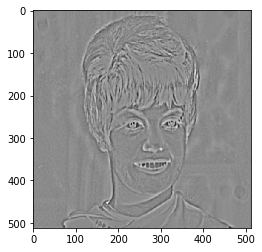

[[-12.76593119 -10.02302017  -8.21792338  -5.37367104  -1.30127787
    2.3874466    5.85886368   9.32374683]
 [-13.74277794 -12.43970825 -11.77759629  -9.68178162  -6.33830767
   -3.17538443   0.73887074   5.86828124]
 [-11.89863319 -12.0483545  -12.36777811 -11.25605837  -9.61970459
   -7.85754785  -4.08605689   2.19606374]
 [ -9.15625195 -10.43926681 -11.11041365 -10.83206233 -11.01211872
  -10.9204148   -7.80102076  -0.9069541 ]
 [ -6.74055661  -8.91296031  -9.59081691 -10.17862485 -11.70601283
  -12.69378526 -10.25142937  -3.26388092]
 [ -4.23909618  -7.47865784  -8.49419102  -9.97769589 -12.48911493
  -14.017278   -11.80911532  -5.21211631]
 [ -0.94283452  -5.53892238  -7.51096835  -9.73069345 -12.99591099
  -14.92278566 -12.77757695  -7.23076015]
 [  2.7839667   -3.15833251  -6.46005461  -9.32262742 -12.8154273
  -14.8924556  -13.39387823  -9.40437584]]


In [10]:
# run this...
from scipy import ndimage

g_small = gaussian_kernel(1) # sigma = 1
g_big = gaussian_kernel(3) # sigma = 3

output_g_small = ndimage.convolve(img.astype('float'), g_small) 
output_g_big = ndimage.convolve(img.astype('float'), g_big) 

output_dog = output_g_big - output_g_small


# the output is a band-pass image, showing selected spatial frequencies of the image

plt.imshow(output_dog, cmap='gray')
plt.show()

# note that the values will be positive and negative
print(output_dog[256:256+8,256:256+8])

## Gaussian and Laplacian Pyramids

In the first lab, we looked the concept of subsampling and how if we want to reduce the
resolution of an image, to avoid aliasing, we need to blurr the image and then subsample.

A Gaussian Pyramid is set of images where each succesive image is a blurred and subsampled
version of the previous one. The subsampling factor is always 2.

If the input image is square and has size $ N = 2^M $, i.e. it is a power of two in size (e.g. 128, 512, 1024, etc.),
we can downsample it by 2, $ M $ times. 

For example an image of size  $ N = 512 $ is the same as
$ N = 2^9 $, so we can subsample 9 times before we end up with a 1 x 1 pixel image (one pixel!).

The resulting set of images form a pyramid structure. The `blur-subsample by 2` opereation is called
the `REDUCE` operation.

Here's an implementation of `REDUCE`:


kernel size is  (3, 3)


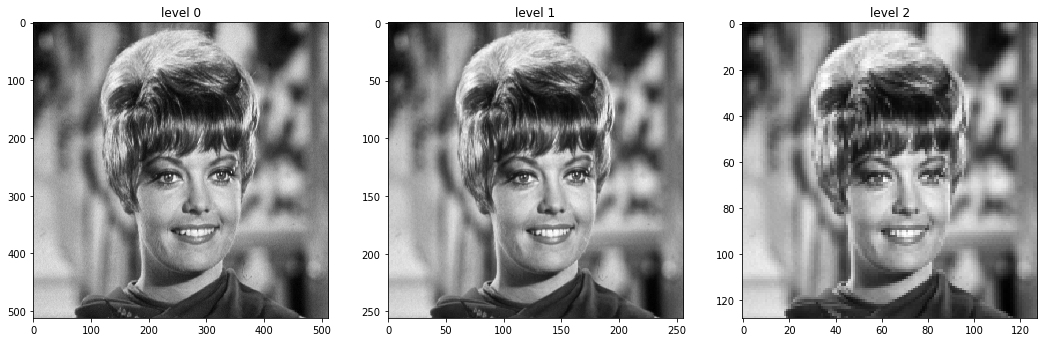

In [11]:
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = ndimage.convolve(im.astype('float'), kernel)    
    return im_blurred[::2,::2] # return subsampled version


# test reduce
g = gaussian_kernel(0.5) 
print('kernel size is ', g.shape)

im_1 = reduce(img, g) # reduce the original
im_2 = reduce(im_1, g) # reduce it again

fig = plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('level 0')

plt.subplot(1,3,2)
plt.imshow(im_1, cmap='gray')

plt.title('level 1')
plt.subplot(1,3,3)

plt.imshow(im_2, cmap='gray')
plt.title('level 2')

plt.show()

## EXPANDing the image after reducing it

The opposite operation to REDUCE is called EXPAND and it tries to do the inverse operation on the reduced
image by upsampling by a factor of 2 (using nearest neigbour interpolation/pixel duplication) and then it 
applies the blurring *after* the upsampling.

We can implement it like this:
    
~~~~
    def expand(im, kernel):
        
        # upsample by a factor of two by pixel duplication
        upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
        
        for i in range(upsampled.shape[0]):
            for j in range(upsampled.shape[1]):
                upsampled[i, j] = im[i//2,j//2]
        
        # blur the upsampled image
        blurred = ndimage.convolve(upsampled.astype('float'), kernel)
        
        return blurred
~~~~

## Exercise 5

1. Implement the `expand` function and test it on a reduced version of the original, e.g.
~~~~
    # test reduce
    g = gaussian_kernel(0.5) 
    print('kernel size is ', g.shape)

    im_1 = reduce(im, g) # reduce the original
    im_2 = reduce(im_1, g) # reduce it again

    # test expand
    print('Expanding')
    ex_1 = expand(im_1, g)
    ex_2 = expand(im_2, g)
~~~~

2. Now do a difference between the expanded and the reduced version at a particular level of
the pyramid, e.g. for level 0 and level 1, we can do:
    
~~~~
    diff_0 = im.astype('float') - ex_1
    diff_1 = im_1 - ex_2
~~~~

    What do these images look like?



kernel size is  (3, 3)
Expanding


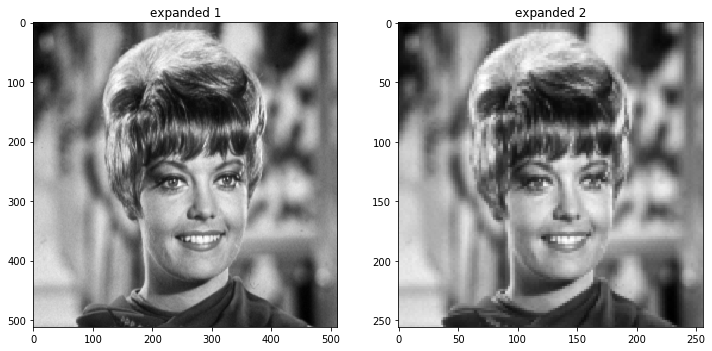

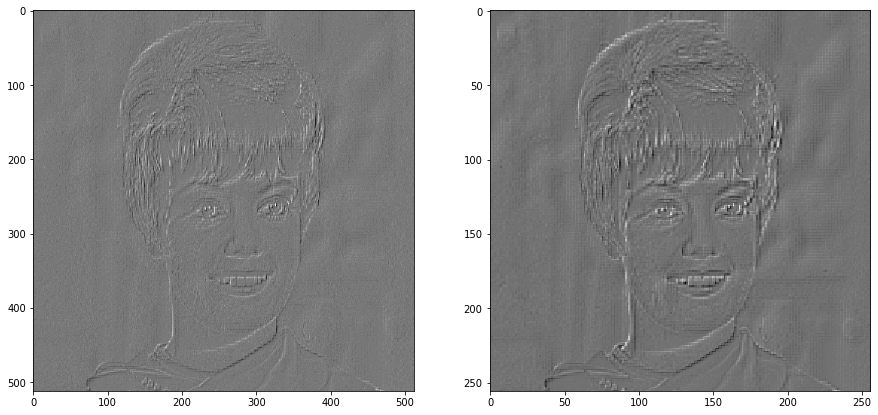

In [12]:
def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)

    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = ndimage.convolve(upsampled.astype('float'), kernel)

    return blurred

# test expand
g = gaussian_kernel(0.5) 
print('kernel size is ', g.shape)

im_1 = reduce(img, g) # reduce the original
im_2 = reduce(im_1, g) # reduce it again

print('Expanding')
ex_1 = expand(im_1, g)
ex_2 = expand(im_2, g)

fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(ex_1, cmap='gray')
plt.title('expanded 1')

plt.subplot(1,2,2)
plt.imshow(ex_2, cmap='gray')

plt.title('expanded 2')

plt.show()

diff_0 = img.astype('float') - ex_1
diff_1 = im_1 - ex_2

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(diff_0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(diff_1, cmap='gray')
plt.show()

## Laplacian Pyramids

You should have noticed that the `diff` images are like the DoG images we made before. This is because
the process of differencing a given Gaussian pyramid level with the expanded version of the level 
above (reduced version of itself), is the same as a DoG filter. (The expanded version of the level above
is a *double* blurred version of the current level, blurred during the REDUCE and blurred in the EXPAND. )

Note that in this image `arithmetic` we can also write:
~~~~
    im_0 = ex_1 + diff_0
    im_1 = ex_2 + diff_1
    im_2 = ex_3 + diff_2
    ...
~~~~

This shows us that left-hand sides are just the Gaussian pyramid levels. 

These multi-level `difference` images are known as Laplacian images and together they form the
Laplacian Pyramid of the input image.



## Exercise 6

In this final exercise, I want you to use the REDUCE and EXPAND operations to build a 
Laplacian Pyramid. You can do this in a for loop and save each Laplacian level in a list.

1. Start by building a Gaussian pyramid and saving all the levels in a list.

For example, to make the Gaussian Pyramid you might write:
~~~~
    
    gauss_pyramid = [] # list to store the generated levels
    
    gauss_pyramid.append(im.astype('float')) # level 0 is the image
    
    n = int(np.log2(im.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):
    
        level = reduce(gauss_pyramid[i-1], g)
        
        gauss_pyramid.append(level)    
~~~~

2. Then, iterate through the Gaussian Pyramid from the top, expanding and differencing with the level below.
Repeat until you reach the bottom of the pyramid.

Note that you should include the top Gaussian Pyramid level in the Laplacian structure.

3. Show that given only the Laplacian Pyramid (including the very smallest Gaussian Pyramid).

You can use the following function to display your pyramid:
~~~~
    def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()
~~~~

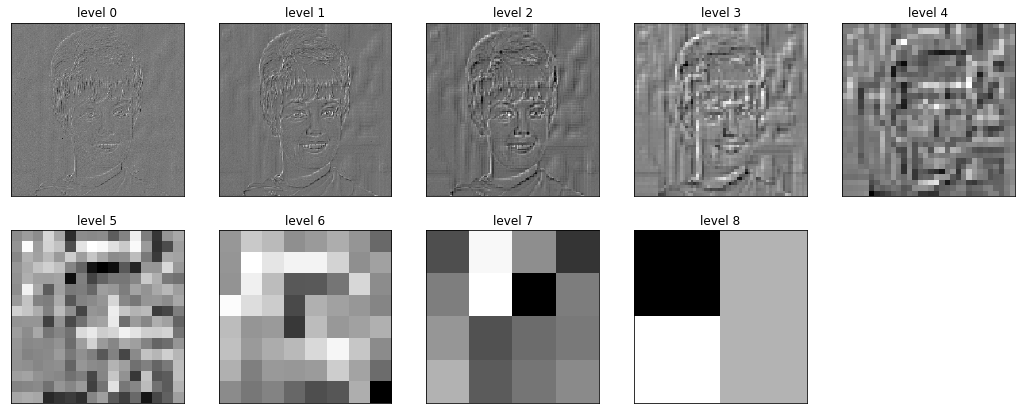

In [19]:
gauss_pyramid = [] # list to store the generated levels

gauss_pyramid.append(img.astype('float')) # level 0 is the image

n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
for i in range(1,n):

    level = reduce(gauss_pyramid[i-1], g)

    gauss_pyramid.append(level)
    
lap_pyramid=[]
for j in range(0,n-1):
    diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
    lap_pyramid.append(diff)
    
def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()
show_pyramid(lap_pyramid)

In [1]:
show_pyramid(gauss_pyramid)

NameError: name 'show_pyramid' is not defined

## Image Compression using Laplacian Pyramids

## Exercise 7

1. Construct a Laplacian Pyramid representation of a gray scale image such as 'zelda.pgm'

2. Plot histograms of the Laplacian values at each level. What do you notice about their distribution?

3. Threshold the Laplacian values which are near-zero (within some percentage of the maximum magnitude, e.g. 2%).

4. Reconstruct the image from your thresholded Laplacian Pyramid and compare the the output with the original.
   Calculate the distortion as mean-squared error and the Signal-to-Noise ratio of the reconstructed image. 

5. If you were to run-length encode the Laplacian Pyramid levels what percentage of the orignal 
   values would be left with?
    
6. Make table of the Lapacian value threshold against the compression ratio/distortion after reconstruction
   as SNR. 

In [24]:
print('test')

test


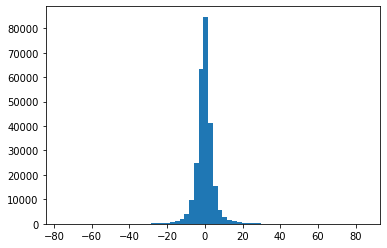

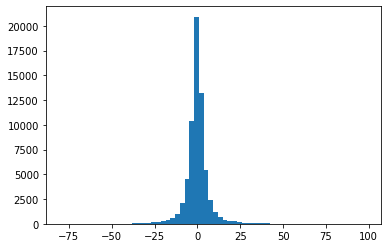

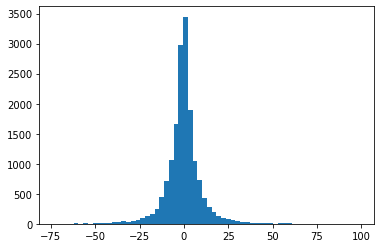

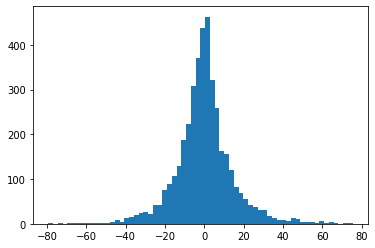

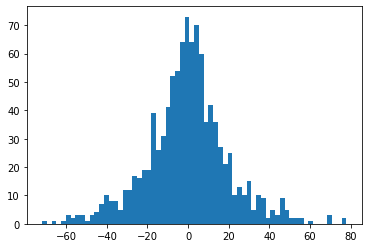

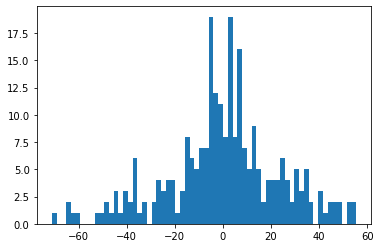

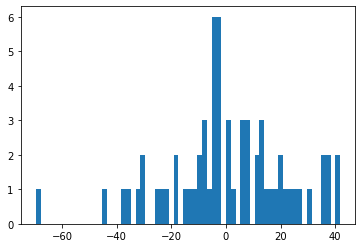

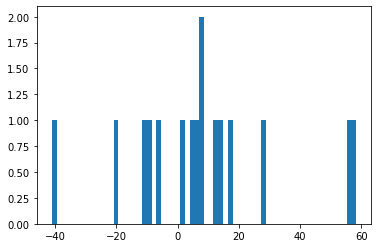

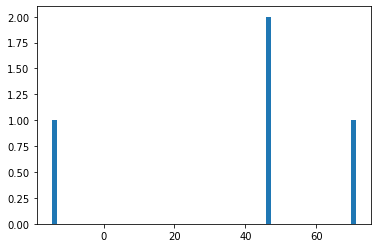

done


In [27]:
for xj in range(len(lap_pyramid)):
    plt.hist(lap_pyramid[xj].ravel(),bins=64)
    plt.show()
print('done')

85.0137058835083
98.09399097791407
98.77622627767053
75.44115155827348
77.92156047760784
55.42663033440405
41.80959809653564
58.31871552342828
71.29966610189122


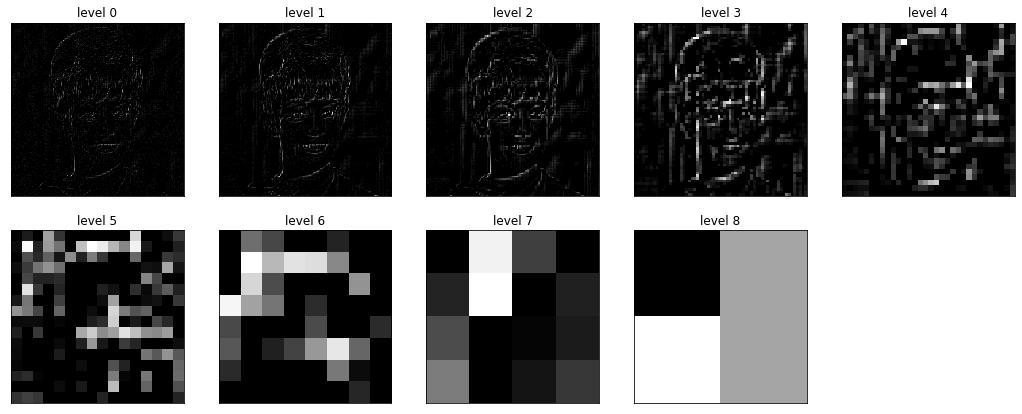

In [44]:
import math
thresh_lap = []
for xj in range(len(lap_pyramid)):
    temp_store = []
    pmax = 0
    for pix in lap_pyramid[xj].ravel():
        if pix>pmax:
            pmax=pix
    print(pmax)
    for pix in lap_pyramid[xj].ravel():
        if pix>(0.02*pmax):
            temp_store.append(pix)
        else:
            temp_store.append(0)
    new_store = np.asarray(temp_store)
    thresh_lap.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))

show_pyramid(thresh_lap)

0
1
2
3
4
5
6
7
8
(512, 512)


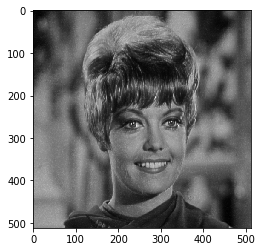

(256, 256)


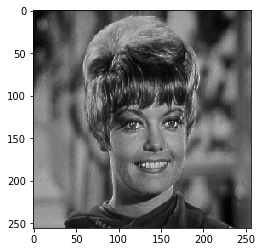

(128, 128)


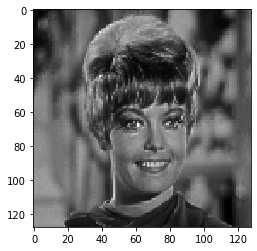

(64, 64)


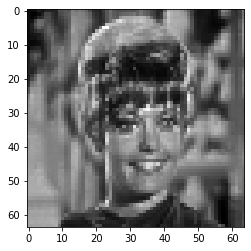

(32, 32)


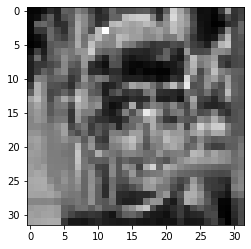

(16, 16)


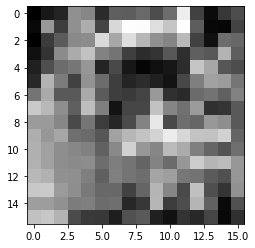

(8, 8)


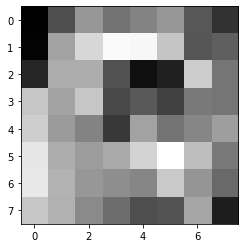

(4, 4)


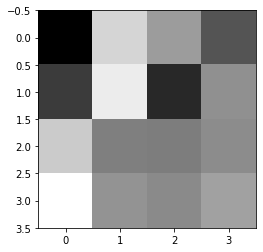

(2, 2)


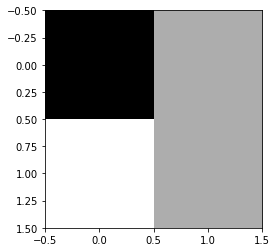

In [52]:
new_comb=[]
for level in range(len(thresh_lap)):
    print(level)
    new_comb.append(gauss_pyramid[level] + thresh_lap[level])

for nc in new_comb:
    print(nc.shape)
    plt.imshow(nc,cmap='gray')
    plt.show()


In [60]:
from sklearn.metrics import mean_squared_error
for i in range(8):
    mse = mean_squared_error(gauss_pyramid[i], new_comb[i])
    print(i,':',mse)

0 : 13.857307564085431
1 : 27.647298477762355
2 : 54.916244039627266
3 : 114.3908381174075
4 : 197.8531681811769
5 : 260.58785670322135
6 : 227.69680229933277
7 : 507.1840385055863


In [66]:
def signaltonoise(a):
    a = np.asanyarray(a)
    m = a.mean(None)
    sd = a.std()
    return np.where(sd == 0, 0, m/sd)
for i in range(8):
    print(i,':',signaltonoise(new_comb[i]))

0 : 2.254116519255454
1 : 2.2525351097054167
2 : 2.2501829834541622
3 : 2.243520063483542
4 : 2.2418734688768738
5 : 2.3266131229592526
6 : 2.675042794979058
7 : 2.5919438676003015
